In [416]:
import glob
import copy
from scipy.misc import imread
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 100} #plotting pretty
from scipy import interpolate

#settings 
#settings for contour plots

c_cmap = 'brg' #colormap for contour plots
c_levels = np.array([0.9, 0.8, 0.6,0.3,0.1]) #energy percentages to contour
interp_val = 10


#get our photo files
datadir = './data/*/Pano*/AP/*_*_*'
ph_files = glob.glob(datadir)

#extract subject IDs
subjects = copy.deepcopy(ph_files)
for i,fname in enumerate(subjects):
    subjects[i] = fname.split('/')[-4]

min image height: 653
min image width: 640


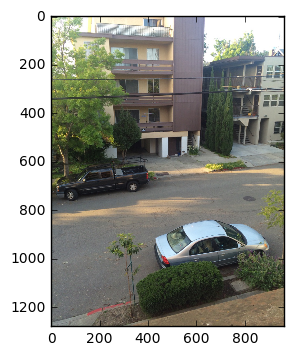

In [410]:
def read_ims(filelist):
    #read in images
    min_h = 10000
    min_w = 10000

    raws = []

    for pf in filelist:
        im = np.asarray(imread(pf))
        raws.append(im)
        #print(np.shape(im))
        #check width and height
        if(min_h) > np.shape(im)[0]:
            min_h = np.shape(im)[0]
        if(min_w) > np.shape(im)[1]:
            min_w = np.shape(im)[1]
    return(raws,min_h,min_w)

raw_images, min_h, min_w = read_ims(ph_files)
plt.imshow(raw_images[21])

print('min image height: {}'.format(min_h))
print('min image width: {}'.format(min_w))

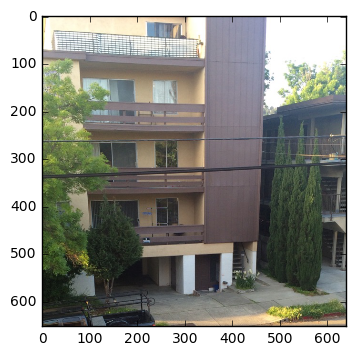

In [411]:
def cropims(ims,crop_h,crop_w,area):
    h_crop_h = np.int(crop_h/2)
    h_crop_w = np.int(crop_w/2)
    #newims = np.ones((np.shape(ims)[0],crop_h,crop_w,3))
    newims = []
    for i, im in enumerate(ims):
        #print(np.shape(im))
        im_h = np.shape(im)[0]
        im_w = np.shape(im)[1]
        h_im_h = np.int(im_h/2) #half image height
        h_im_w = np.int(im_w/2) #half image width
        if(area=='middle'):
            newim = im[h_im_h-h_crop_h:h_im_h+h_crop_h, #crop height
                       h_im_w-h_crop_w:h_im_w+h_crop_w, #crop width
                       :]
        elif(area=='top'):
             newim = im[0:crop_h, #crop height
                       h_im_w-h_crop_w:h_im_w+h_crop_w, #crop width
                       :]
        elif(area=='bottom'):
             newim = im[im_h-crop_h:im_h, #crop height
                       h_im_w-h_crop_w:h_im_w+h_crop_w, #crop width
                       :]
        else:
            raise ValueError('area not well specified!')
        #print(np.shape(newim))
        #newims[i,:,:,:] = newim
        newims.append(newim)
    return(newims)

images_middle = cropims(raw_images,min_h,min_w,'middle')
images_top = cropims(raw_images,min_h,min_w,'top')
images_bottom = cropims(raw_images,min_h,min_w,'bottom')

images = images_top

sim = images[21]
plt.imshow(sim)

(-0.5, 639.5, 652.5, -0.5)

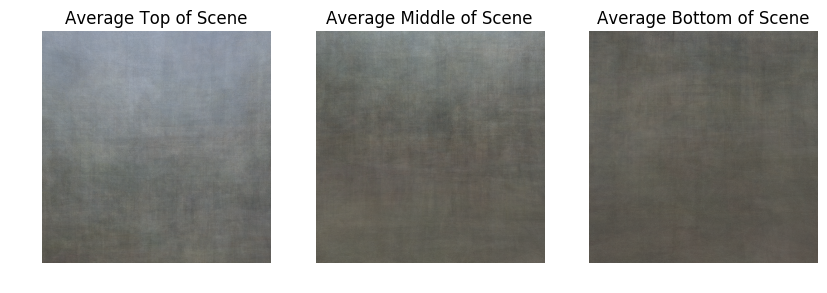

In [412]:
def avgims(ims):
    ims_arr = np.asarray(ims)
    #average images  - first index must be list of images
    avg = np.zeros_like(ims_arr[0])
    #print(np.shape(avg))
    for c in range(np.shape(avg)[2]): #loop over R, G, and B
        avg[:,:,c] = np.mean(ims_arr[:,:,:,c],axis=0)
    return(avg)

avgim = avgims(images)
avgim_top = avgims(images_top)
avgim_middle = avgims(images_middle)
avgim_bottom = avgims(images_bottom)

plt.figure(figsize=(10,3))

plt.subplot(1,3,1,title='Average Top of Scene')
plt.imshow(avgim_top)
plt.axis('off')
plt.subplot(1,3,2,title='Average Middle of Scene')
plt.imshow(avgim_middle)
plt.axis('off')
plt.subplot(1,3,3,title='Average Bottom of Scene')
plt.imshow(avgim_bottom)
plt.axis('off')

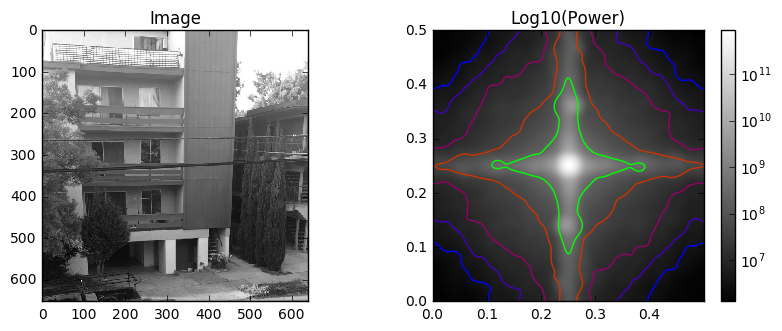

In [446]:
def spatialft(image):
    # Take the fourier transform of the image.
    # shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image
    greyavgim = np.mean(np.asarray(image),axis=2) #average over colors
    greyavgim =  greyavgim - np.mean(greyavgim) #remove DC component
    ft = np.abs(np.fft.fftshift(np.fft.fft2(greyavgim)))
    fqs = np.abs([np.fft.fftshift(np.fft.fftfreq(np.shape(greyavgim)[0])),np.fft.fftshift(np.fft.fftfreq(np.shape(greyavgim)[1]))])
    ps = ft**2
    return(greyavgim, ft, ps, fqs)

simage, ft2d, ps2d, sfqs = spatialft(sim)

def get_logspace_contours(raw_field):
    log_field = np.log10(raw_field)
    field = log_field/log_field.sum()
    n = 1000
    t = np.linspace(0, field.max(), n)
    integral = ((field >= t[:, None, None]) * field).sum(axis=(1,2))
    f = interpolate.interp1d(integral, t)
    t_contours = f(c_levels)*log_field.sum()
    linear_t_contours = 10**t_contours
    return(linear_t_contours)

#2d power spectra
plt.figure(figsize=(10, 3.5))
plt.subplots(nrows=1,ncols=2,figsize =(10,3.5))

plt.subplot(1,2,1,title='Image')
plt.imshow(simage, interpolation='none',cmap='gray')

plt.subplot(1,2,2,title='Log10(Power)')
interp_ps2d = scipy.ndimage.filters.gaussian_filter(ps2d,interp_val)

sim_contours = get_logspace_contours(interp_ps2d)
plt.imshow(interp_ps2d, cmap="gray", norm=mpl.colors.LogNorm(),
           extent=[sfqs[0].min(),sfqs[0].max(),sfqs[1].min(),sfqs[1].max()])
plt.colorbar()
plt.contour(interp_ps2d,levels=sim_contours, cmap=c_cmap, norm = mpl.colors.LogNorm(),
           extent=[sfqs[0].min(),sfqs[0].max(),sfqs[1].min(),sfqs[1].max()])


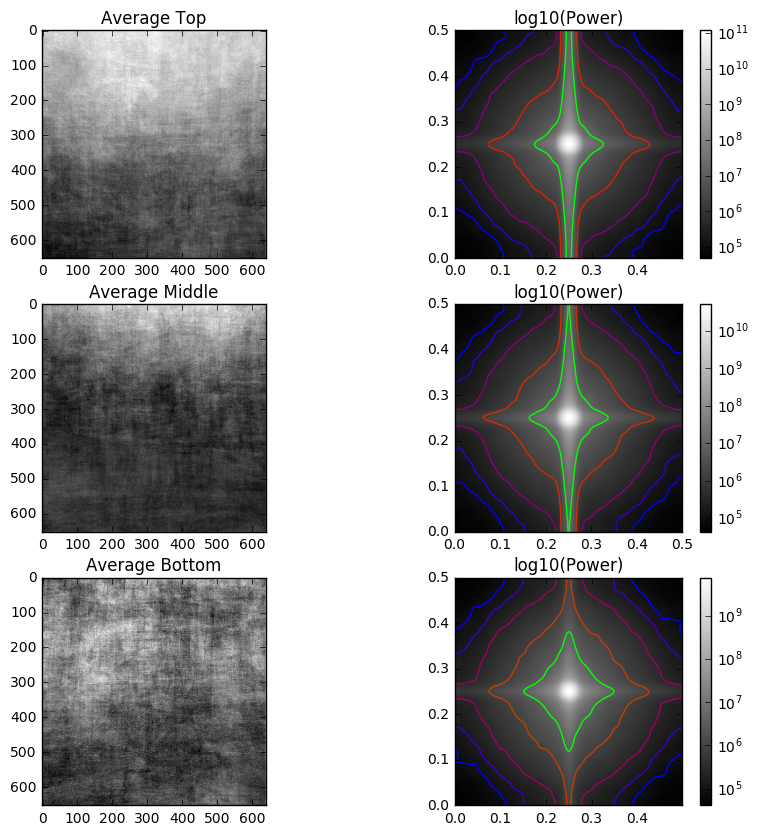

In [447]:
#2d power spectra
#plt.figure(figsize=(10, 10))
#fig,axes=
plt.subplots(nrows=1,ncols=2,figsize =(10,10))

#AVERAGE TOP
image_top, ft2d_top, ps2d_top, fqs_top = spatialft(avgim_top)
plt.subplot(3,2,1,title='Average Top')
plt.imshow(image_top, interpolation='none',cmap='gray')

plt.subplot(3,2,2,title='log10(Power)')
interp_ps2d_top = scipy.ndimage.filters.gaussian_filter(ps2d_top,interp_val)
plt.imshow(interp_ps2d_top, cmap="gray", norm=mpl.colors.LogNorm(),
            extent=[fqs_top[0].min(),fqs_top[0].max(),fqs_top[1].min(),fqs_top[1].max()])
plt.colorbar()
sim_contours_top = get_logspace_contours(interp_ps2d_top)
plt.contour(interp_ps2d_top,levels=sim_contours_top, cmap=c_cmap ,norm = mpl.colors.LogNorm(),
            extent=[fqs_top[0].min(),fqs_top[0].max(),fqs_top[1].min(),fqs_top[1].max()])

#AVERAGE MIDDLE
image_middle, ft2d_middle, ps2d_middle, fqs_middle = spatialft(avgim_middle)
plt.subplot(3,2,3,title='Average Middle')
plt.imshow(image_middle, interpolation='none',cmap='gray')

plt.subplot(3,2,4,title='log10(Power)')
interp_ps2d_middle = scipy.ndimage.filters.gaussian_filter(ps2d_middle,interp_val)
plt.imshow(interp_ps2d_middle, cmap="gray", norm=mpl.colors.LogNorm(),
            extent=[fqs_middle[0].min(),fqs_middle[0].max(),fqs_middle[1].min(),fqs_middle[1].max()])
plt.colorbar()
sim_contours_middle = get_logspace_contours(interp_ps2d_middle)
plt.contour(interp_ps2d_middle,levels=sim_contours_middle, cmap=c_cmap ,norm = mpl.colors.LogNorm(),
             extent=[fqs_middle[0].min(),fqs_middle[0].max(),fqs_middle[1].min(),fqs_middle[1].max()])


#AVERAGE BOTTOM
image_bottom, ft2d_bottom, ps2d_bottom, fqs_bottom = spatialft(avgim_bottom)
plt.subplot(3,2,5,title='Average Bottom')
plt.imshow(image_bottom, interpolation='none',cmap='gray')

plt.subplot(3,2,6,title='log10(Power)')
interp_ps2d_bottom = scipy.ndimage.filters.gaussian_filter(ps2d_bottom,interp_val)
plt.imshow(interp_ps2d_bottom, cmap="gray", norm=mpl.colors.LogNorm(),
          extent=[fqs_bottom[0].min(),fqs_bottom[0].max(),fqs_bottom[1].min(),fqs_bottom[1].max()])
plt.colorbar()
sim_contours_bottom = get_logspace_contours(interp_ps2d_bottom)
plt.contour(interp_ps2d_bottom,levels=sim_contours_bottom, cmap=c_cmap ,norm = mpl.colors.LogNorm(),
           extent=[fqs_bottom[0].min(),fqs_bottom[0].max(),fqs_bottom[1].min(),fqs_bottom[1].max()])


(-0.5, 639.5, 651.5, -0.5)

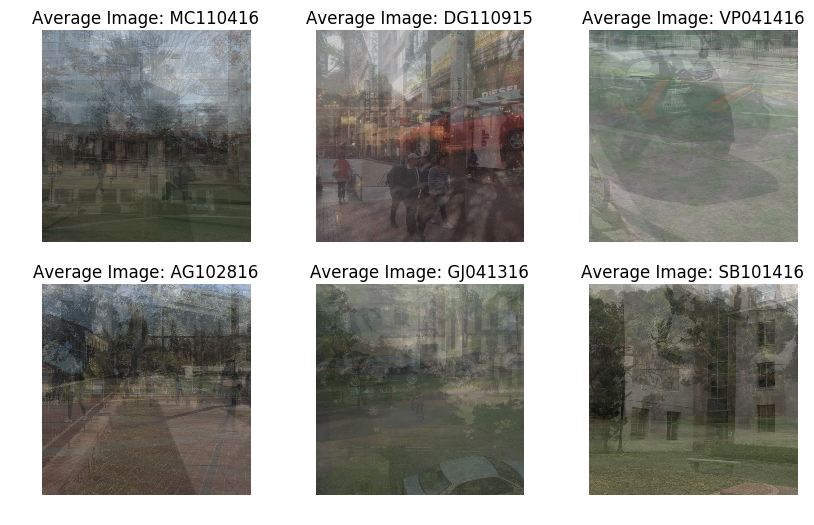

In [484]:
#Look at individual subjects

usubs = np.unique(subjects)
sub_avgims = []

#go through each unique subject
for i, usub in enumerate(usubs):
    sub_idxs = [i for i,x in enumerate(subjects) if x == usub]
    #print(sub_idxs)
    #print(np.shape(images_middle))
    #print(type(images_middle))
    subims = np.array(images_middle)[sub_idxs]
    sub_avgim = avgims(subims)
    sub_avgims.append(sub_avgim)
    
#plot the average image for some subjects
trs = np.random.choice(np.arange(len(sub_avgims)),6,replace=False)

plt.figure(figsize=(10,6))

plt.subplot(2,3,1,title='Average Image: {}'.format(usubs[trs[0]]))
plt.imshow(sub_avgims[trs[0]])
plt.axis('off')
plt.subplot(2,3,2,title='Average Image: {}'.format(usubs[trs[1]]))
plt.imshow(sub_avgims[trs[1]])
plt.axis('off')
plt.subplot(2,3,3,title='Average Image: {}'.format(usubs[trs[2]]))
plt.imshow(sub_avgims[trs[2]])
plt.axis('off')
plt.subplot(2,3,4,title='Average Image: {}'.format(usubs[trs[3]]))
plt.imshow(sub_avgims[trs[3]])
plt.axis('off')
plt.subplot(2,3,5,title='Average Image: {}'.format(usubs[trs[4]]))
plt.imshow(sub_avgims[trs[4]])
plt.axis('off')
plt.subplot(2,3,6,title='Average Image: {}'.format(usubs[trs[5]]))
plt.imshow(sub_avgims[trs[5]])
plt.axis('off')

In [ ]:
plt.subplots(nrows=1,ncols=2,figsize =(10,10))

#AVERAGE TOP
image_top, ft2d_top, ps2d_top, fqs_top = spatialft(avgim_top)
plt.subplot(3,2,1,title='Average Top')
plt.imshow(image_top, interpolation='none',cmap='gray')

plt.subplot(3,2,2,title='log10(Power)')
interp_ps2d_top = scipy.ndimage.filters.gaussian_filter(ps2d_top,interp_val)
plt.imshow(interp_ps2d_top, cmap="gray", norm=mpl.colors.LogNorm(),
            extent=[fqs_top[0].min(),fqs_top[0].max(),fqs_top[1].min(),fqs_top[1].max()])
plt.colorbar()
sim_contours_top = get_logspace_contours(interp_ps2d_top)
plt.contour(interp_ps2d_top,levels=sim_contours_top, cmap=c_cmap ,norm = mpl.colors.LogNorm(),
            extent=[fqs_top[0].min(),fqs_top[0].max(),fqs_top[1].min(),fqs_top[1].max()])

#AVERAGE MIDDLE
image_middle, ft2d_middle, ps2d_middle, fqs_middle = spatialft(avgim_middle)
plt.subplot(3,2,3,title='Average Middle')
plt.imshow(image_middle, interpolation='none',cmap='gray')

plt.subplot(3,2,4,title='log10(Power)')
interp_ps2d_middle = scipy.ndimage.filters.gaussian_filter(ps2d_middle,interp_val)
plt.imshow(interp_ps2d_middle, cmap="gray", norm=mpl.colors.LogNorm(),
            extent=[fqs_middle[0].min(),fqs_middle[0].max(),fqs_middle[1].min(),fqs_middle[1].max()])
plt.colorbar()
sim_contours_middle = get_logspace_contours(interp_ps2d_middle)
plt.contour(interp_ps2d_middle,levels=sim_contours_middle, cmap=c_cmap ,norm = mpl.colors.LogNorm(),
             extent=[fqs_middle[0].min(),fqs_middle[0].max(),fqs_middle[1].min(),fqs_middle[1].max()])


#AVERAGE BOTTOM
image_bottom, ft2d_bottom, ps2d_bottom, fqs_bottom = spatialft(avgim_bottom)
plt.subplot(3,2,5,title='Average Bottom')
plt.imshow(image_bottom, interpolation='none',cmap='gray')

plt.subplot(3,2,6,title='log10(Power)')
interp_ps2d_bottom = scipy.ndimage.filters.gaussian_filter(ps2d_bottom,interp_val)
plt.imshow(interp_ps2d_bottom, cmap="gray", norm=mpl.colors.LogNorm(),
          extent=[fqs_bottom[0].min(),fqs_bottom[0].max(),fqs_bottom[1].min(),fqs_bottom[1].max()])
plt.colorbar()
sim_contours_bottom = get_logspace_contours(interp_ps2d_bottom)
plt.contour(interp_ps2d_bottom,levels=sim_contours_bottom, cmap=c_cmap ,norm = mpl.colors.LogNorm(),
           extent=[fqs_bottom[0].min(),fqs_bottom[0].max(),fqs_bottom[1].min(),fqs_bottom[1].max()])

Todo:
contours of individual subjets
calculate alpha and A for a given image